# PV forecasting benchmark

Example created by Wilson Rocha Lacerda Junior

## Note

The following example is **not** intended to say that one library is better than another. The main focus of these examples is to show that SysIdentPy can be a good alternative for people looking to model time series.

We will compare the results obtained against **neural prophet** library.

For the sake of brevity, from **SysIdentPy** only the **MetaMSS**, **AOLS** and **FROLS** (with polynomial base function) methods will be used. See the SysIdentPy documentation to learn other ways of modeling with the library.


We will compare a 1-step ahead forecaster on solar irradiance data (that can be a proxy for solar PV production). The config of the neuralprophet model was taken from the neuralprophet documentation (https://neuralprophet.com/html/example_links/energy_data_example.html)

The training will occur on 80% of the data, reserving the last 20% for the validation.

Note: the data used in this example can be found in neuralprophet github.

In [1]:
from warnings import simplefilter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sysidentpy.model_structure_selection import FROLS, AOLS, MetaMSS
from sysidentpy.basis_function import Polynomial
from sysidentpy.parameter_estimation import LeastSquares
from sysidentpy.utils.plotting import plot_results
from sysidentpy.neural_network import NARXNN
from sysidentpy.metrics import mean_squared_error

from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed


simplefilter("ignore", FutureWarning)
np.seterr(all="ignore")

%matplotlib inline

loss = mean_squared_error

data_location = r".\datasets"

## FROLS

3869.3472912979273


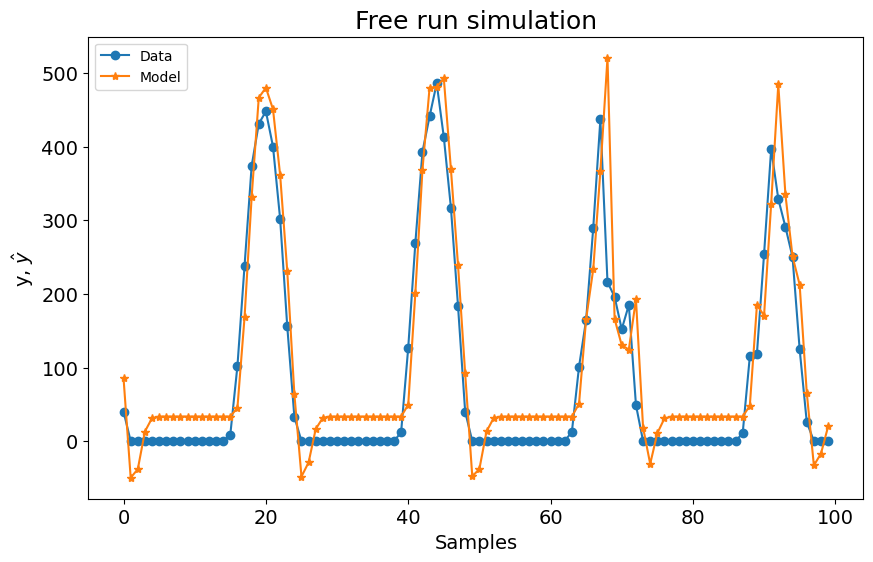

In [2]:
files = ["\SanFrancisco_PV_GHI.csv", "\SanFrancisco_Hospital.csv"]
raw = pd.read_csv(data_location + files[0])
df = pd.DataFrame()
df["ds"] = pd.date_range("1/1/2015 1:00:00", freq=str(60) + "Min", periods=(8760))
df["y"] = raw.iloc[:, 0].values

df_train, df_val = df.iloc[:7008, :], df.iloc[7008:, :]

y = df["y"].values.reshape(-1, 1)
y_train = df_train["y"].values.reshape(-1, 1)
y_test = df_val["y"].values.reshape(-1, 1)

x_train = df_train["ds"].dt.hour.values.reshape(-1, 1)
x_test = df_val["ds"].dt.hour.values.reshape(-1, 1)

basis_function = Polynomial(degree=1)
sysidentpy = FROLS(
    order_selection=True,
    ylag=24,
    xlag=24,
    info_criteria="bic",
    basis_function=basis_function,
    model_type="NARMAX",
    estimator=LeastSquares(),
)

sysidentpy.fit(X=x_train, y=y_train)
x_test = np.concatenate([x_train[-sysidentpy.max_lag :], x_test])
y_test = np.concatenate([y_train[-sysidentpy.max_lag :], y_test])

yhat = sysidentpy.predict(X=x_test, y=y_test, steps_ahead=1)
sysidentpy_loss = loss(
    pd.Series(y_test.flatten()[sysidentpy.max_lag :]),
    pd.Series(yhat.flatten()[sysidentpy.max_lag :]),
)
print(sysidentpy_loss)


plot_results(y=y_test[-104:], yhat=yhat[-104:])

## MetaMSS

2157.7700127350877


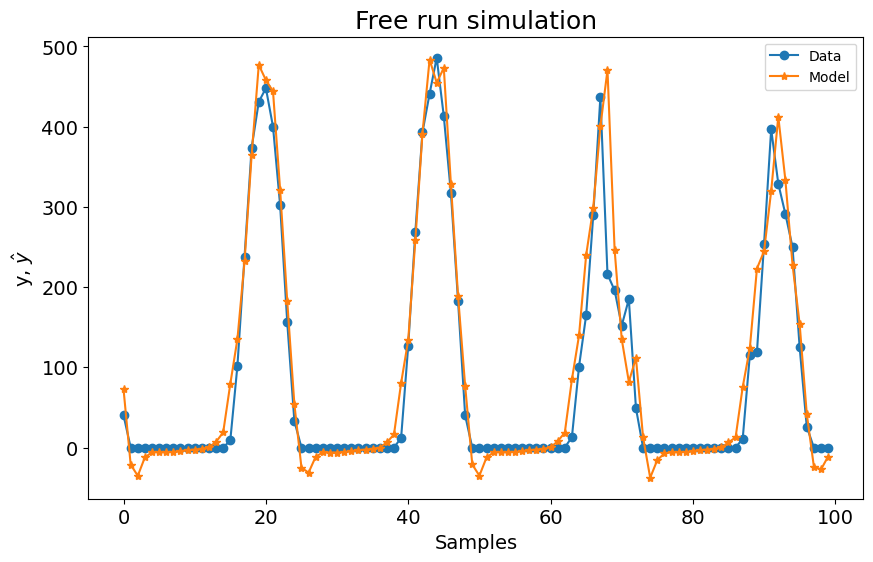

In [4]:
set_random_seed(42)
files = ["\SanFrancisco_PV_GHI.csv", "\SanFrancisco_Hospital.csv"]
raw = pd.read_csv(data_location + files[0])
df = pd.DataFrame()
df["ds"] = pd.date_range("1/1/2015 1:00:00", freq=str(60) + "Min", periods=(8760))
df["y"] = raw.iloc[:, 0].values

df_train, df_val = df.iloc[:7008, :], df.iloc[7008:, :]

y = df["y"].values.reshape(-1, 1)
y_train = df_train["y"].values.reshape(-1, 1)
y_test = df_val["y"].values.reshape(-1, 1)

x_train = df_train["ds"].dt.hour.values.reshape(-1, 1)
x_test = df_val["ds"].dt.hour.values.reshape(-1, 1)

basis_function = Polynomial(degree=1)
estimator = LeastSquares()
sysidentpy_metamss = MetaMSS(
    basis_function=basis_function,
    xlag=24,
    ylag=24,
    estimator=estimator,
    maxiter=10,
    steps_ahead=1,
    n_agents=15,
    loss_func="metamss_loss",
    model_type="NARMAX",
    random_state=42,
)
sysidentpy_metamss.fit(X=x_train, y=y_train)
x_test = np.concatenate([x_train[-sysidentpy_metamss.max_lag :], x_test])
y_test = np.concatenate([y_train[-sysidentpy_metamss.max_lag :], y_test])

yhat = sysidentpy_metamss.predict(X=x_test, y=y_test, steps_ahead=1)
metamss_loss = loss(
    pd.Series(y_test.flatten()[sysidentpy_metamss.max_lag :]),
    pd.Series(yhat.flatten()[sysidentpy_metamss.max_lag :]),
)
print(metamss_loss)


plot_results(y=y_test[-104:], yhat=yhat[-104:])

## AOLS

2361.561682547365


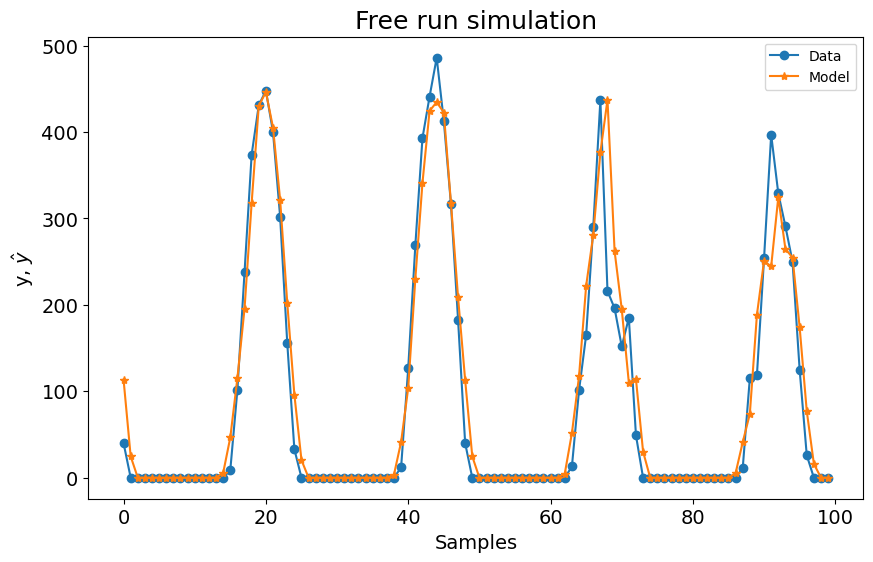

In [7]:
set_random_seed(42)
files = ["\SanFrancisco_PV_GHI.csv", "\SanFrancisco_Hospital.csv"]
raw = pd.read_csv(data_location + files[0])
df = pd.DataFrame()
df["ds"] = pd.date_range("1/1/2015 1:00:00", freq=str(60) + "Min", periods=(8760))
df["y"] = raw.iloc[:, 0].values

df_train, df_val = df.iloc[:7008, :], df.iloc[7008:, :]

y = df["y"].values.reshape(-1, 1)
y_train = df_train["y"].values.reshape(-1, 1)
y_test = df_val["y"].values.reshape(-1, 1)

x_train = df_train["ds"].dt.hour.values.reshape(-1, 1)
x_test = df_val["ds"].dt.hour.values.reshape(-1, 1)
basis_function = Polynomial(degree=1)
sysidentpy_AOLS = AOLS(
    ylag=24, xlag=24, k=2, L=1, model_type="NARMAX", basis_function=basis_function
)
sysidentpy_AOLS.fit(X=x_train, y=y_train)
x_test = np.concatenate([x_train[-sysidentpy_AOLS.max_lag :], x_test])
y_test = np.concatenate([y_train[-sysidentpy_AOLS.max_lag :], y_test])

yhat = sysidentpy_AOLS.predict(X=x_test, y=y_test, steps_ahead=1)
aols_loss = loss(
    pd.Series(y_test.flatten()[sysidentpy_AOLS.max_lag :]),
    pd.Series(yhat.flatten()[sysidentpy_AOLS.max_lag :]),
)
print(aols_loss)


plot_results(y=y_test[-104:], yhat=yhat[-104:])

## Neural Prophet

In [6]:
set_random_seed(42)

# set_log_level("ERROR")
files = ["\SanFrancisco_PV_GHI.csv", "\SanFrancisco_Hospital.csv"]
raw = pd.read_csv(data_location + files[0])
df = pd.DataFrame()
df["ds"] = pd.date_range("1/1/2015 1:00:00", freq=str(60) + "Min", periods=(8760))
df["y"] = raw.iloc[:, 0].values

m = NeuralProphet(
    n_lags=24,
    ar_sparsity=0.5,
    # num_hidden_layers = 2,
    # d_hidden=20,
)
metrics = m.fit(df, freq="H", valid_p=0.2)

df_train, df_val = m.split_df(df, valid_p=0.2)
m.test(df_val)

future = m.make_future_dataframe(df_val, n_historic_predictions=True)
forecast = m.predict(future)
# fig = m.plot(forecast)
print(loss(forecast["y"][24:-1], forecast["yhat1"][24:-1]))

04-26 20:16:52 - WARNING - Parts of code may break if using other than daily data.


INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.


04-26 20:16:52 - INFO - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32


04-26 20:16:52 - INFO - Auto-set batch_size to 32


INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


04-26 20:16:52 - INFO - Auto-set epochs to 7


 87%|████████▋ | 87/100 [00:00<00:00, 617.37it/s]
INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-01


04-26 20:16:52 - INFO - learning rate range test found optimal lr: 1.23E-01


Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.61it/s, SmoothL1Loss=0.00415, MAE=58.8, RegLoss=0.0112]
INFO: nprophet - _evaluate: Validation metrics:    SmoothL1Loss    MAE
1         0.003 48.746


04-26 20:16:55 - INFO - Validation metrics:    SmoothL1Loss    MAE
1         0.003 48.746
4642.234763049609


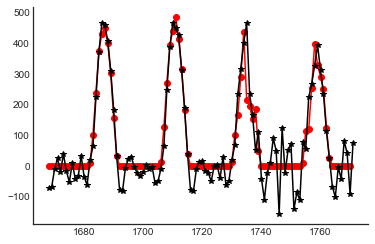

In [7]:
plt.plot(forecast["y"][-104:], "ro-")
plt.plot(forecast["yhat1"][-104:], "k*-")